## Structured-output vision example for Ollama 

Creates a synthetic image with matplotlib, saves it to a temporary PNG,
then sends it to an LLM that supports image inputs and JSON-schema outputs.


### Import Libraries

In [52]:
import tempfile
from pathlib import Path
from typing import Literal, List
import socket
import psutil
import subprocess
import time
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arc
from pydantic import BaseModel
from ollama import chat
from IPython.display import display

### Start the Ollama Server

In [23]:
def is_port_in_use(port: int = 11434) -> bool:
    """Check if the Ollama port is already in use"""
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        return s.connect_ex(('localhost', port)) == 0

def is_ollama_running() -> bool:
    """Check if Ollama process is running"""
    for proc in psutil.process_iter(['name']):
        try:
            if proc.info['name'] == 'ollama':
                return True
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass
    return False
def ensure_ollama_server():
    """
    Ensures that an Ollama server is running.
    Returns the process object if a new server was started, None if server was already running.
    """
    # First check if the server is already running
    if is_ollama_running():
        print("✅ Ollama server is already running!")
        return None
    
    try:
        # Start the Ollama server
        print("🚀 Starting Ollama server...")
        proc = subprocess.Popen(
            ["ollama", "serve"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            start_new_session=True
        )
        
        # Wait for the server to start (max 10 seconds)
        for _ in range(10):
            if is_port_in_use():
                print(f"✅ Ollama server started successfully (PID: {proc.pid})")
                return proc
            time.sleep(1)
            
        raise TimeoutError("Server didn't start within 10 seconds")
        
    except Exception as e:
        print(f"❌ Error starting Ollama server: {e}")
        if 'proc' in locals():
            proc.terminate()
        raise

In [24]:
# Start the server if it's not already running
ollama_process = ensure_ollama_server()

🚀 Starting Ollama server...
✅ Ollama server started successfully (PID: 2289006)


In [25]:
!ollama ls

NAME                      ID              SIZE      MODIFIED   
llama3.2-vision:latest    6f2f9757ae97    7.8 GB    3 days ago    
llama3.1:latest           46e0c10c039e    4.9 GB    3 days ago    
llama3.2:1b               baf6a787fdff    1.3 GB    4 days ago    
llava:latest              8dd30f6b0cb1    4.7 GB    5 days ago    
qwen3:0.6b                7df6b6e09427    522 MB    5 days ago    


## Target JSON Schema

In [26]:
# ---------- 1. Build the target JSON schema ---------- #
class Object(BaseModel):
    name: str
    confidence: float
    attributes: str


class ImageDescription(BaseModel):
    summary: str
    objects: List[Object]
    scene: str
    colors: List[str]
    time_of_day: Literal["Morning", "Afternoon", "Evening", "Night"]
    setting: Literal["Indoor", "Outdoor", "Unknown"]
    text_content: str | None = None

## Simple Dummy Image to test out

In [27]:
# ---------- 2. Create a simple image with matplotlib ---------- #
def create_shapes_figure(path: Path, show: bool = True) -> plt.Figure:
    """
    Draw three colored shapes, save to `path`, and optionally display inline.
    
    Args:
      path: where to write the PNG
      show: if True, render the figure in the notebook
    Returns:
      The matplotlib Figure object
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_aspect("equal")
    ax.axis("off")

    # Red circle
    ax.add_patch(Circle((0.25, 0.75), 0.2, color="red"))

    # Green square
    ax.add_patch(Rectangle((0.6, 0.6), 0.25, 0.25, color="green"))

    # Blue triangle
    triangle = Polygon([[0.2, 0.2], [0.5, 0.2], [0.35, 0.45]], color="blue")
    ax.add_patch(triangle)

    # save to disk
    fig.savefig(path, bbox_inches="tight", pad_inches=0)

    if show:
        # 1) this will render inline in most Jupyter setups
        plt.show()
        # —or— you can do: display(fig)
        # display(fig)

    # if you don’t want to keep it open on-screen afterwards, you can:
    plt.close(fig)
    return fig

#### Generate the image and save it to a .png file

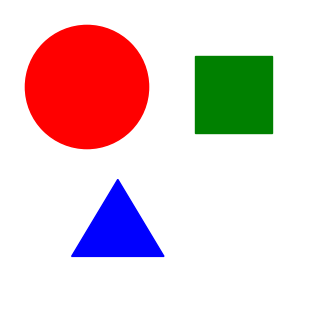

Image saved at: /tmp/tmpo7b9puag.png


In [28]:
# ---------- 3. Generate the image file in a temp directory ---------- #
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
    img_path = Path(tmp.name)

create_shapes_figure(img_path)
print(f"Image saved at: {img_path}")  # Optional: confirm location


## Strucutred Output request for images using Ollama

In [29]:
# ---------- 4. Send the image to the LLM with structured-output request ---------- #
response = chat(
    model="llama3.2-vision",                      # Make sure this model is available locally
    format=ImageDescription.model_json_schema(),  # Instruct the model to reply with this schema
    messages=[
        {
            "role": "user",
            "content": (
                "Please analyze this figure and return a detailed JSON description. "
                "Include a high-level summary, all detected objects with confidences, "
                "dominant colors, scene type, and any visible text. "
                "If a field is unknown, leave it empty."
            ),
            "images": [img_path],                 # Supply the generated PNG
        }
    ],
    options={"temperature": 0},                   # Deterministic output
)
# ---------- 5. Parse the response back into our Pydantic class ---------- #
image_analysis = ImageDescription.model_validate_json(response.message.content)
print("\nStructured vision output:\n", image_analysis)



Structured vision output:
 summary='A simple graphic with a red circle, blue triangle, and green square.' objects=[Object(name='Red Circle', confidence=0.9999999999999999, attributes='red'), Object(name='Blue Triangle', confidence=0.9999999999999999, attributes='blue'), Object(name='Green Square', confidence=0.9999999999999999, attributes='green')] scene='Simple Graphic' colors=['red', 'blue', 'green'] time_of_day='Afternoon' setting='Indoor' text_content=None


# Example 1: Emoji Sentiment

### Goal: Detect whether the face is “happy” or “sad” and return:
   * emotion: Literal["Happy", "Sad"]
   * confidence: float (0-1)

In [49]:
class FaceSentiment(BaseModel):
    emotion: Literal["Happy", "Sad"]
    confidence: float

In [70]:
def draw_face(
    path: Path,
    emotion: Literal["happy", "sad"] = "happy",
    show: bool = False,
) -> plt.Figure:
    """
    Draw a happy 🙂 or sad 🙁 face and save it to `path`.

    Args:
        path: destination PNG file
        emotion: "happy" or "sad"
        show: whether to display inline in the notebook
    Returns:
        matplotlib Figure
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_aspect("equal")
    ax.axis("off")

    # ------------ Head ------------
    ax.add_patch(Circle((0.5, 0.5), 0.48, color="#ffd966", ec="black", lw=1))

    # ------------ Eyes ------------
    ax.add_patch(Circle((0.33, 0.65), 0.06, color="black"))
    ax.add_patch(Circle((0.67, 0.65), 0.06, color="black"))

    # ------------ Mouth ------------
    if emotion == "happy":
        theta1, theta2, y = 200, 340, 0.52   # broad smile
    else:  # sad
        theta1, theta2, y = 40, 140, 0.25    # downward arc
    ax.add_patch(
        Arc(
            (0.5, y),      # centre of arc
            width=0.6,
            height=0.4,
            angle=0,
            theta1=theta1,
            theta2=theta2,
            lw=8,
            color="black",
        )
    )

    fig.savefig(path, bbox_inches="tight", pad_inches=0)
    if show:
        plt.show()
    plt.close(fig)
    return fig
    



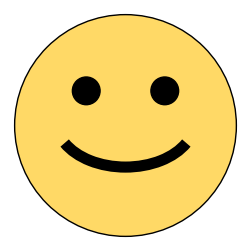

In [74]:
draw_face(img_path, emotion="happy")

In [75]:
# Structured-output request to the vision-LLM
response = chat(
    model="llama3.2-vision",
    format=FaceSentiment.model_json_schema(),
    messages=[
        {
            "role": "user",
            "content": (
                "Detect whether this face is happy or sad and respond with JSON "
                "containing keys `emotion` and `confidence`."
            ),
            "images": [img_path],
        }
    ],
    options={"temperature": 0},
)

print(FaceSentiment.model_validate_json(response.message.content))

emotion='Happy' confidence=0.9


# Example 2: Reading a Bar Chart

###  Goal: Extract category names and bar heights.


In [42]:
class BarValue(BaseModel):
    label: str
    value: float


class ChartData(BaseModel):
    bars: List[BarValue]
    title: str

In [46]:
def draw_bar_chart(path: Path) -> None:
    labels = ["Cats", "Dogs", "Birds", "Fish"]
    values = np.random.randint(1, 10, size=len(labels))
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.bar(labels, values, color=["#8ecae6", "#219ebc", "#023047", "#ffb703"])
    ax.set_title("Pets owned by students")
    plt.show()
    fig.savefig(path, bbox_inches="tight")
    plt.close(fig)

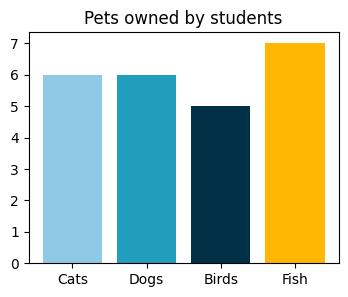

In [47]:
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
    img_path = Path(tmp.name)
draw_bar_chart(img_path)

In [48]:
response = chat(
    model="llama3.2-vision",
    format=ChartData.model_json_schema(),
    messages=[
        {
            "role": "user",
            "content": (
                "Return a JSON list of the bar labels and their heights as numbers, "
                "plus the chart title."
            ),
            "images": [img_path],
        }
    ],
    options={"temperature": 0}
)
print(ChartData.model_validate_json(response.message.content))


bars=[BarValue(label='Cats', value=6.0), BarValue(label='Dogs', value=6.0), BarValue(label='Birds', value=5.0), BarValue(label='Fish', value=7.0)] title='Pets owned by students'


## Example X: Traffic-Light State
### Goal: Detect which light (red/yellow/green) is illuminated.

In [30]:
class TrafficSignal(BaseModel):
    light: Literal["Red", "Yellow", "Green"]
    confidence: float

In [38]:
def draw_traffic_light(path: Path, state: Literal["red", "yellow", "green"]) -> None:
    assert state in ["red", "yellow", "green"]
    fig, ax = plt.subplots(figsize=(2, 4))
    ax.axis("off")
    # Housing
    ax.add_patch(Rectangle((0.1, 0.05), 0.8, 0.9, color="#333333"))
    # Lights
    colors = {"red": ("red", "#333333", "#333333"),
              "yellow": ("#333333", "yellow", "#333333"),
              "green": ("#333333", "#333333", "limegreen")}
    r, y, g = colors[state]
    ax.add_patch(Circle((0.5, 0.8), 0.15, color=r))
    ax.add_patch(Circle((0.5, 0.5), 0.15, color=y))
    ax.add_patch(Circle((0.5, 0.2), 0.15, color=g))
    plt.show()
    fig.savefig(path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)


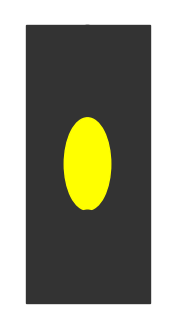

In [39]:
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
    img_path = Path(tmp.name)
draw_traffic_light(img_path, state="yellow")  # change state as desired

In [40]:
response = chat(
    model="llama3.2-vision",
    format=TrafficSignal.model_json_schema(),
    messages=[
        {
            "role": "user",
            "content": (
                "What color is the active traffic light? "
                "Respond with JSON containing `light` and `confidence`."
            ),
            "images": [img_path],
        }
    ],
    options={"temperature": 0}
)

In [41]:
print(TrafficSignal.model_validate_json(response.message.content))


light='Yellow' confidence=0.9
